# 予測（１回）

Epoch 1/100
1/3 [=========>....................] - ETA: 0s - loss: 0.1045
Epoch 1: val_loss improved from inf to 0.06465, saving model to best_model.h5
3/3 [==============================] - 1s 55ms/step - loss: 0.0772 - val_loss: 0.0647
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 0.0530
Epoch 2: val_loss improved from 0.06465 to 0.06440, saving model to best_model.h5
3/3 [==============================] - 0s 13ms/step - loss: 0.0574 - val_loss: 0.0644
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 0.0523
Epoch 3: val_loss did not improve from 0.06440
3/3 [==============================] - 0s 9ms/step - loss: 0.0495 - val_loss: 0.0731
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 0.0604
Epoch 4: val_loss did not improve from 0.06440
3/3 [==============================] - 0s 9ms/step - loss: 0.0538 - val_loss: 0.0710
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 0.0583
Epoch 5: val_loss did not improve 

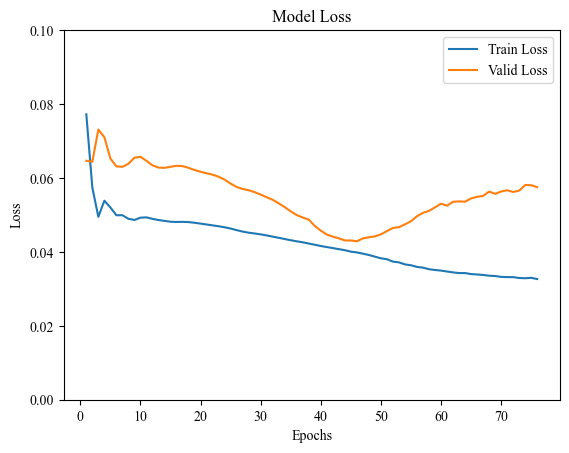

1/1 [==============================] - 0s 11ms/step


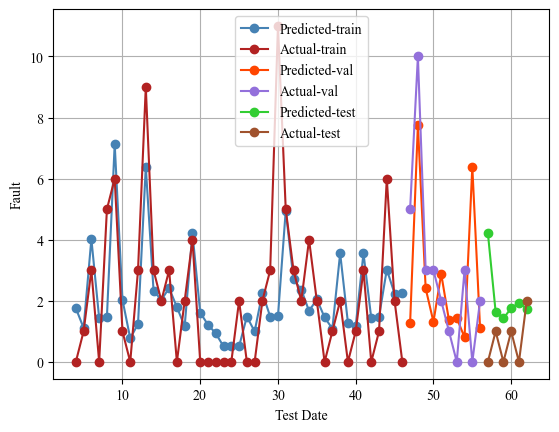

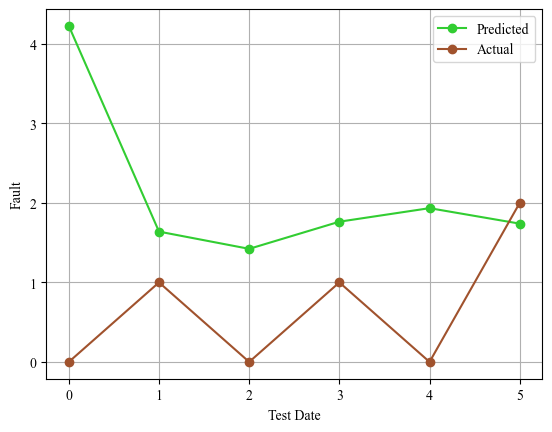

MSE 4.112327767705611
RMSE 2.0278875135730803


In [3]:
import numpy as np
import pandas as pd
import csv

from libs import nnsrp

def main():
  # set random seed
  seed = 911
  nnsrp.set_random_seed(seed)

  file_name = "../Dataset//ds1.csv"
  data = read_csv(file_name)
  # create cumulative data
  # cum_data = np.cumsum(data)

  # hyperparamaters
  params_dict = {
    "time_lag": 3,
    "test_size_rate": .1,
    "hidden_units": 200,
    "batch_size": 16,
    "epochs": 100,
    "learning_rate": 0.01,
    "activation_func": "relu",
    "validation": True,
    "val_size_rate": 0.2,
    "earlystopping": True,
    "best_model": True,
    "verbose": 1,
  }

  predictor(data, params_dict, verbose=1, graph_plot=True)

# read text file
def read_file(file_name):
  with open(file_name, 'r') as f:
    list = f.readlines()
    data = np.array([int(ele.split()[1]) for ele in list])
    return np.array(data)
  
def read_csv(file_name):
  with open(file_name, 'r') as f:
    reader = csv.reader(f)
    next(reader)
    data = np.array([int(ele[1]) for ele in reader])
  return data

def predictor(data, params_dict, verbose=0, graph_plot=False):
  # set hyperparams as global variable
  nnsrp.set_hyperparams(params_dict)

  # normalize data
  data, scaler = nnsrp.normalization(data)

  # devide train data and test data
  X_train, X_test, y_train, y_test = nnsrp.make_data(data)

  # create NN model
  model = nnsrp.create_model()
  
  # train NN model
  history = nnsrp.train_model(model, X_train, y_train, verbose=verbose)

  # plot history graph
  if graph_plot:
    nnsrp.plot_learning_history(history)

  # predict
  y_train_pred = nnsrp.predict_train_data(model, X_train, verbose=verbose)
  y_test_pred = nnsrp.predict_test_data(model, X_test, verbose=verbose)

  # inverse normalization
  y_train = nnsrp.inverse_normalization(y_train, scaler)
  y_test = nnsrp.inverse_normalization(y_test, scaler)
  y_train_pred = nnsrp.inverse_normalization(y_train_pred, scaler)
  y_test_pred = nnsrp.inverse_normalization(y_test_pred, scaler)

  if graph_plot:
    # plot predicted value
    nnsrp.plot_result(y_train, y_test, y_train_pred, y_test_pred)
    nnsrp.plot_only_testdata(y_test, y_test_pred)

    nnsrp.print_mse(y_test, y_test_pred)
  return y_test_pred

if __name__ == "__main__":
  main()

## 複数回予測し，予測値の平均を取る（アンサンブル）

Current status: 1/3...
[4.1801796  2.38587712 1.4019566  1.4928882  1.95676626 2.27705985]


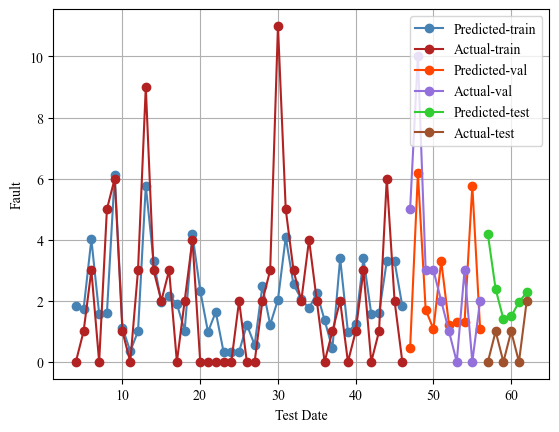

Current status: 2/3...
[3.87728846 1.94892959 1.40916204 1.95219572 2.31752549 2.05204728]


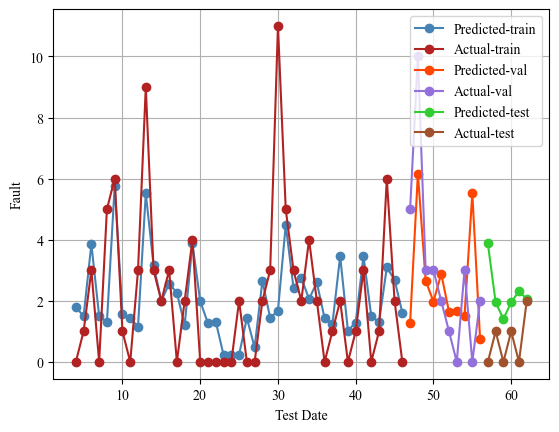

Current status: 3/3...
[4.32368982 1.8134706  1.12514235 1.49050441 1.63751417 0.95120451]


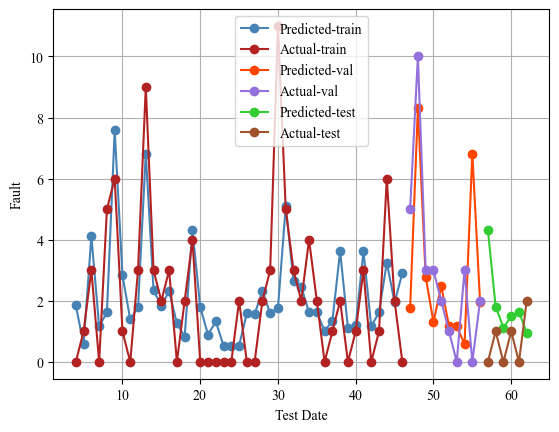

In [4]:
import numpy as np
import pandas as pd
import csv
import os

from libs import nnsrp

def main():
  file_name = "../Dataset//ds1.csv"
  data = read_csv(file_name)
  # create cumulative data
  # cum_data = np.cumsum(data)

  # hyperparamaters
  params_dict = {
    "time_lag": 3,
    "test_size_rate": .1,
    "hidden_units": 200,
    "batch_size": 16,
    "epochs": 100,
    "learning_rate": 0.01,
    "activation_func": "relu",
    "validation": True,
    "val_size_rate": 0.2,
    "earlystopping": True,
    "best_model": True,
    "verbose": 1,
  }

  # set hyperparams as global variable
  nnsrp.set_hyperparams(params_dict)

  y_test, pred_list = predictor_multi(data, repeat=3, seed_init=100)

  # print(pred_list)
  # save in file
  if not os.path.exists("result/ensemble_pred_value"):
    os.makedirs("result/ensemble_pred_value")
  np.savetxt("result_pred.csv", pred_list, delimiter=',')

# read text file
def read_csv(file_name):
  with open(file_name, 'r') as f:
    reader = csv.reader(f)
    next(reader)
    data = np.array([int(ele[1]) for ele in reader])
  return data

def predictor_multi(data, repeat, seed_init, verbose=0):
  # devide train data and test data
  X_train, X_test, y_train, y_test = nnsrp.make_data(data)
  
  # normalize data
  data_norm, scaler = nnsrp.normalization(data)

  # devide train data and test data
  X_train_norm, X_test_norm, y_train_norm, y_test_norm = nnsrp.make_data(data_norm)
  
  pred_list = np.array([])
  for seed in range(repeat):
    # print currrent status
    print("Current status: ", seed+1, '/', repeat, "...",  sep='')
    # set random seed
    nnsrp.set_random_seed(seed_init+seed)

    # create NN model
    model = nnsrp.create_model() 
    
    # train NN model
    history = nnsrp.train_model(model, X_train_norm, y_train_norm, verbose=verbose)

    # predict
    y_train_pred_norm = nnsrp.predict_train_data(model, X_train_norm, verbose=verbose)
    y_test_pred_norm = nnsrp.predict_test_data(model, X_test_norm, verbose=verbose)

    # inverse normalization
    y_train_pred = nnsrp.inverse_normalization(y_train_pred_norm, scaler)
    y_test_pred = nnsrp.inverse_normalization(y_test_pred_norm, scaler)
    print(y_test_pred)

    nnsrp.plot_result(y_train, y_test, y_train_pred, y_test_pred)

    pred_list = np.append(pred_list, y_test_pred)

  pred_list = pred_list.reshape(-1, len(y_test))
  return y_test, pred_list

if __name__ == "__main__":
  main()

## WSEがある場合とない場合で予測値を比較

Current status: 1/10...
Current status: 2/10...
Current status: 3/10...
Current status: 4/10...
Current status: 5/10...
Current status: 6/10...
Current status: 7/10...
Current status: 8/10...
Current status: 9/10...
Current status: 10/10...
Current status: 1/10...
Current status: 2/10...
Current status: 3/10...
Current status: 4/10...
Current status: 5/10...
Current status: 6/10...
Current status: 7/10...
Current status: 8/10...
Current status: 9/10...
Current status: 10/10...
Without WSE: 
MSE 4.389560431399852
RMSE 2.095127784026514
With WSE: 
MSE 1.9481015404527675
RMSE 1.3957440812888184


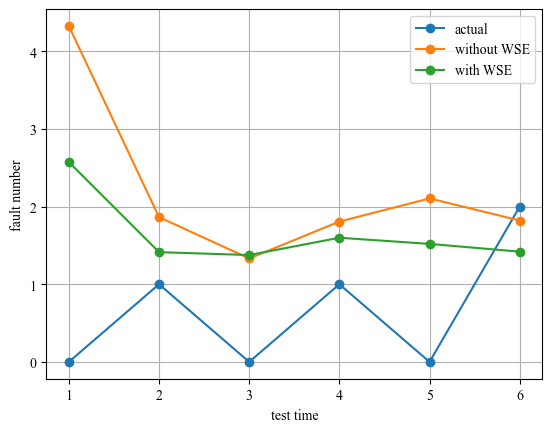

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import os
import sys
sys.path.append(os.path.abspath('..'))

import csv

from libs import nnsrp
from wavelet_shrinkage_estimation import wse_v2 as wse

plt.rcParams['font.family'] = 'Times New Roman'

def main():
  file_name = "../Dataset/ds1.csv"
  data = read_csv(file_name)
  # create cumulative data
  # cum_data = np.cumsum(data)

  # hyperparamaters
  params_dict = {
    "time_lag": 3,
    "test_size_rate": .1,
    "hidden_units": 200,
    "batch_size": 16,
    "epochs": 100,
    "learning_rate": 0.01,
    "activation_func": "relu",
    "validation": True,
    "val_size_rate": 0.2,
    "earlystopping": True,
    "best_model": True,
    "verbose": 1,
  }

  # set hyperparams as global variable
  nnsrp.set_hyperparams(params_dict)

  repeat = 10
  seed_init = 100
  # prediction without WSE
  y_test, pred_list = predictor_multi(data, repeat=repeat, seed_init=seed_init)
  y_pred_mean = pred_list.mean(axis=0)

  # prediction with WSE
  data_wse = wse.WSEbaseNHPP(data, "HAT", "s", "lht")
  data_wse = np.array(data_wse)
  _, pred_list_wse = predictor_multi(data_wse, repeat=repeat, seed_init=seed_init)
  y_pred_wse_mean = pred_list_wse.mean(axis=0)

  # save in file
  if not os.path.exists("result/compare_pred_value"):
    os.makedirs("result/compare_pred_value")
  np.savetxt("result/compare_pred_value/without_wse.csv", pred_list, delimiter=',')
  np.savetxt("result/compare_pred_value/with_wse.csv", pred_list_wse, delimiter=',')

  # print result
  print("Without WSE: ")
  nnsrp.print_mse(y_test, y_pred_mean)
  print("With WSE: ")
  nnsrp.print_mse(y_test, y_pred_wse_mean)

  # graph plot
  plt.plot(range(1, len(y_test)+1), y_test, marker='o', label="actual")
  plt.plot(range(1, len(y_pred_mean)+1), y_pred_mean, marker='o', label="without WSE")
  plt.plot(range(1, len(y_pred_wse_mean)+1), y_pred_wse_mean, marker='o', label="with WSE")
  plt.xlabel("test time")
  plt.ylabel("fault number")
  plt.grid()
  plt.legend()
  plt.show()

# read text file
def read_csv(file_name):
  with open(file_name, 'r') as f:
    reader = csv.reader(f)
    next(reader)
    data = np.array([int(ele[1]) for ele in reader])
  return data

def predictor_multi(data, repeat, seed_init, verbose=0):
  # devide train data and test data
  X_train, X_test, y_train, y_test = nnsrp.make_data(data)
  
  # normalize data
  data_norm, scaler = nnsrp.normalization(data)

  # devide train data and test data
  X_train_norm, X_test_norm, y_train_norm, y_test_norm = nnsrp.make_data(data_norm)
  
  pred_list = np.array([])
  for seed in range(repeat):
    # print currrent status
    print("Current status: ", seed+1, '/', repeat, "...",  sep='')
    # set random seed
    nnsrp.set_random_seed(seed_init+seed)

    # create NN model
    model = nnsrp.create_model() 
    
    # train NN model
    history = nnsrp.train_model(model, X_train_norm, y_train_norm, verbose=verbose)

    # predict
    y_train_pred_norm = nnsrp.predict_train_data(model, X_train_norm, verbose=verbose)
    y_test_pred_norm = nnsrp.predict_test_data(model, X_test_norm, verbose=verbose)

    # inverse normalization
    y_train_pred = nnsrp.inverse_normalization(y_train_pred_norm, scaler)
    y_test_pred = nnsrp.inverse_normalization(y_test_pred_norm, scaler)
    # print(y_test_pred)
    # plot_result(y_train, y_test, y_train_pred, y_test_pred)

    pred_list = np.append(pred_list, y_test_pred)

  pred_list = pred_list.reshape(-1, len(y_test))
  return y_test, pred_list


if __name__ == "__main__":
  main()